From below result, we learned that SMOTE can help our model to perform better than original dataset:
![imbalanced data](images/6.PNG) <br/>

## <font color='darkblue'>Exploratory of exist techniques to handle imbalanced data</font>
Here we are going to do some experiment to appy well know techniques in handling imbalanced data and and do a comparison for their performance and give summary or personal point of view in the end.

Then, we can choose proper way from those techniques to improve the performance of our model ([original notebook link](https://github.com/bhattbhavesh91/imbalance_class_sklearn/blob/master/imbalance_class_undersampling_oversampling_updated.ipynb)) according to certain scenarios. The agenda of this section is as below:
* [**Baseline**](#baseline)
* [**Undersampling**](#undersampling)
* [**Oversampling**](#oversampling)
* [**Other Machine Learning Model (SVM)**](#other_models_svm)
* [**Other Machine Learning Mode (XGBoost)**](#other_models_xgboost)
* [**Evaluation of all techniques**](#evaluation)
* [**Anomaly Detection**](#anomaly)

<a id='baseline'></a>
### <font color='darkgreen'>Baseline</font>
Firstly, to import necessary packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Configure chart setting:

In [2]:
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
rdm_state = 19

Then for some utility functions:

In [3]:
def generate_model_report(y_actual, y_predicted):
    accuracy, precision, recall, f1 = accuracy_score(y_actual, y_predicted), precision_score(y_actual, y_predicted), recall_score(y_actual, y_predicted), f1_score(y_actual, y_predicted)
    print("Accuracy  = {:.03f}".format(accuracy))
    print("Precision = {:.03f}".format(precision))
    print("Recall    = {:.03f}".format(recall))
    print("F1 Score  = {:.03f}".format(f1))
    return accuracy, precision, recall, f1

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
def train_with_time(clf, X, y):
    st = datetime.now()
    clf.fit(X, y)
    return clf, (datetime.now() - st).total_seconds()

For the csv to be loaded in below, please go to [this link](https://github.com/bhattbhavesh91/imbalance_class_sklearn/blob/master/data.rar) to download `data.rar` which is related to Credit Card Fraud Detection and decompress it. (Or download the data from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) )

In [4]:
%time df = pd.read_csv('data.csv', engine='python')

Wall time: 1.52 s


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [6]:
df.shape

(57355, 31)

Then let's separate the features `X` and labels `Y`:

In [7]:
target_column_name = 'Class'
X = df.loc[:, df.columns!=target_column_name]
Y = df.loc[:, df.columns==target_column_name]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=rdm_state)
perf_store = {}
time_cost_store = {}

In [8]:
# Check the distribution of class which is total imbalanced data
Y_train['Class'].value_counts()

0    38106
1      321
Name: Class, dtype: int64

In [9]:
Y_test.head(10) # Check ID sequence: 26116, 19018, 44788, ... to confirm the random sate is as expected

,Class
26116,0
19018,0
44788,0
4928,0
56279,0
42632,0
5787,0
17837,0
24982,0
37586,0


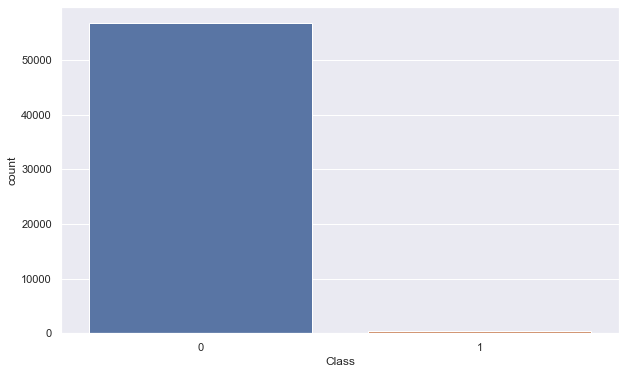

In [10]:
ax = sns.countplot(x=target_column_name, data=df)

In [11]:
percent_of_minority = 100* (len(Y_train[Y_train['Class'] == 1])/float(Y_train.shape[0]))
percent_of_majority = 100* (len(Y_train[Y_train['Class'] == 0])/float(Y_train.shape[0]))
print("minority percentage={:.02f}%; majority percentage={:.02f}%".format(percent_of_minority, percent_of_majority))
print("minority is {:.02f}% of majority".format(100*percent_of_minority/percent_of_majority))

minority percentage=0.84%; majority percentage=99.16%
minority is 0.84% of majority


It is obvious that his data set is imbalanced. <b>The class of minority is less than 1% of the total data set! </b> (should be more sharp while this data set is the 20% sampling result of the original data set) <br/> <br/>
Let's see the distribution of classes in tSNE:

In [12]:
# This cell will take a long time...
from sklearn.manifold import TSNE

%time X_embedded = TSNE(n_components=3).fit_transform(X_train)

Wall time: 8min 31s


In [13]:
X_embedded.shape

(38427, 3)

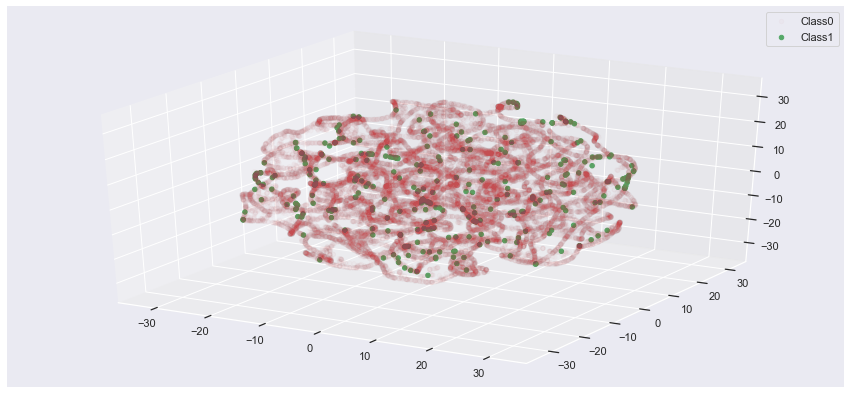

In [14]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(15, 7))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
for i, c, label in zip([0, 1], colors, ["Class0", "Class1"]):
    alpha = 1 if i == 1 else 0.02
    ax.scatter(        
        X_embedded[Y_train['Class'] == i, 0],
        X_embedded[Y_train['Class'] == i, 1], 
        X_embedded[Y_train['Class'] == i, 2], c=c, label=label, alpha=alpha)
    
plt.legend()
plt.show()

From the output of [**tSNE**](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (<font color='brown'>similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.</font>), it seems that the <b>data point of two classes are mingled together which implies we may need some feature engineering here</b>. 

Now let's check the performance of model with default hyper-parameters:

In [15]:
# Training
# clf = LogisticRegression().fit(X_train, Y_train)
clf, tt = train_with_time(LogisticRegression(), X_train, Y_train)

In [16]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [17]:
# Confusion table
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18735,44
1,22,127


We have 43 data point here as FN (actual class is 1 but got prediction as 0); 28 data point as FP (actual class is 0 but got prediction as 1 ). Let's generate the report for common performance index:

In [18]:
model_name = 'lr_baseline'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.997
Precision = 0.852
Recall    = 0.743
F1 Score  = 0.794


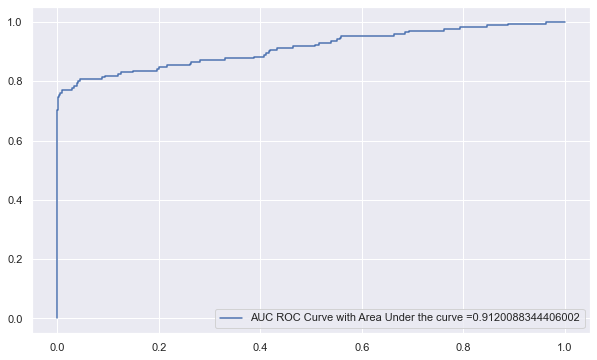

In [19]:
generate_auc_roc_curve(clf, X_test)

For more about ROC curve, please refer to this [post](http://mlwiki.org/index.php/ROC_Analysis). The Y axis is TPR (True Positive Rate) and X axis is FPR (False positive Rate)

<a id='undersampling'></a>
### <font color=darkgreen>Undersampling</font>
The first weapon we are going to use is called "Undersampling" ([imbalanced doc](https://imbalanced-learn.org/stable/under_sampling.html)) which is the reduce the size of majority class to be close to the size of minority class. First approach we are going to apply is [**ClusterCentroids**](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.ClusterCentroids.html):

In [20]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=rdm_state)
%time X_train_cc, Y_train_cc = cc.fit_sample(X_train, Y_train)

Wall time: 31 s


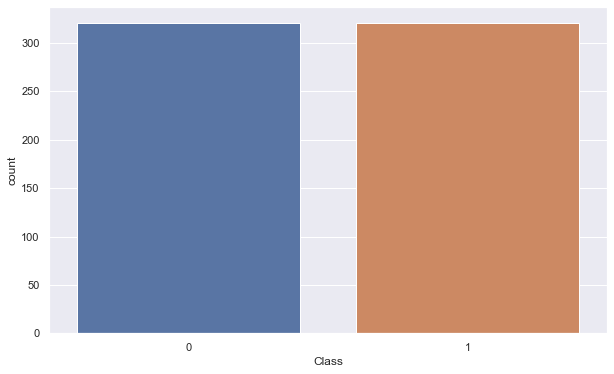

In [21]:
# The size of minority is 324. So we reduce the size of majority to 324 too
sns.countplot(Y_train_cc['Class'])

In [22]:
# Training
clf, tt = train_with_time(LogisticRegression(), X_train_cc, Y_train_cc)

In [23]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [24]:
# Confusion table
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,16454,11
1,2303,160


In [25]:
model_name = 'lr_us_cc'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.878
Precision = 0.065
Recall    = 0.936
F1 Score  = 0.121


Our TP is improved from <font color='green'>127 to 160 (Recall 0.74->0.93)</font>; however, the FP is deteriorated <font color='red'>from 22 to **2297** (Precision 0.85->0.06)</font>! <br/><br/>

Let's try another method called [**Tomek**](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.TomekLinks.html#imblearn.under_sampling.TomekLinks) ([Illustration of the definition of a Tomek link](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_illustration_tomek_links.html?highlight=Tomek)):
![Tomek idea](images/10.PNG)

In [26]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='not minority')
tl.fit(X_train, Y_train)
%time X_train_tl, Y_train_tl = tl.fit_sample(X_train, Y_train)

Wall time: 944 ms


In [27]:
X_train_tl.shape

(38343, 30)

In [28]:
X_train.shape

(38427, 30)

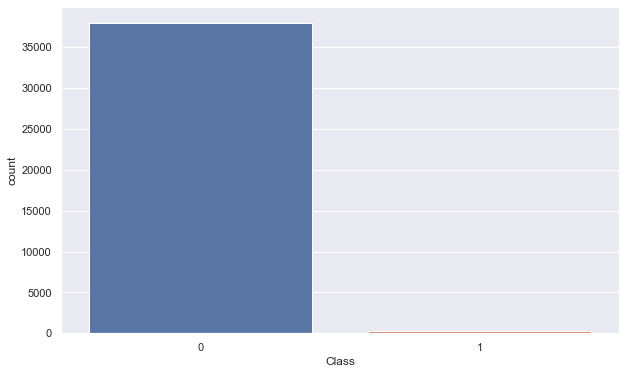

In [29]:
# The size of minority is 324. So we reduce the size of majority to 324 too
sns.countplot(Y_train_tl['Class'])

In [30]:
# Training
clf, tt = train_with_time(LogisticRegression(), X_train_tl, Y_train_tl)

In [31]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [32]:
# Confusion table
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18744,45
1,13,126


In [33]:
model_name = 'lr_us_tl'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.997
Precision = 0.906
Recall    = 0.737
F1 Score  = 0.813


Our TP is almost the same from <font color='red'>127->126</font>; but, the FP is slightly improved <font color='green'>from 22 to 13</font>! <br/><br/>
There are more undersampling approaches supported by [imblean package](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling) and you can try by yourself:
![other imbalanced approaches](images/11.PNG)
<br/>

### <font color='darkgreen'>class_weight='balanced'</font>
From the [lesson here](https://www.youtube.com/watch?v=Kp31wfHpG2c&list=PLyQnbMWK6HUVWtYO8H2SRZLFc99oznMYU&index=6&t=541s), we learned that some classifier(s) from <b>[scikit-learn](https://scikit-learn.org/stable/index.html)</b> support handling of imbalanced data. Take <b>[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn-linear-model-logisticregression)</b> for example, it support argument `class_weight`:
```
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
```
Now let's check what performance impact can `class_weight='balanced'` bring in:

Let's calculate the weight for each class based on the amount of data of each class:

In [34]:
unique_classes = [0, 1]
out_dict = {}
for clz in unique_classes:
    out_dict[clz] = df.shape[0]/((df.loc[df[target_column_name] == clz].shape[0]) * len(unique_classes))

In [35]:
out_dict

{0: 0.5043261875032974, 1: 58.28760162601626}

<b>Because class 0 is a majority, so the weighting of it is smaller than the class 1.</b> Above is a example to calculate the weighting of class. Now let's train the classifier with `class_weight='balanced'`:

In [36]:
# clf = LogisticRegression(class_weight='balanced').fit(X_train, Y_train)
clf, tt = train_with_time(LogisticRegression(class_weight='balanced'), X_train, Y_train)

In [37]:
from sklearn.utils import class_weight
# The weighting calculated by scikit-learn
class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train[target_column_name])

array([ 0.50421194, 59.85514019])

Now let's check the performance:

In [38]:
Y_Test_Pred = clf.predict(X_test)
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18183,20
1,574,151


TP is improved from <font color='green'>127 to 151 (Recall 0.74->0.88)</font>; however, the FP is increased too <font color='red'>from 22 to **574** (Precision 0.81->0.20)</font>! <br/><br/>

In [39]:
model_name = 'lr_cw'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.969
Precision = 0.208
Recall    = 0.883
F1 Score  = 0.337


In [40]:
weights = np.linspace(0.01, 0.5, 50)
weights

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

We can do one more step to find out the optimal weighting by [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

In [41]:
# The execution in this cell will take a long time
weights = np.linspace(0.01, 0.6, 60)
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

%time grid_result, tt = train_with_time(gsc, X_train, Y_train)
print("Best parameters : %s" % gsc.best_params_)
optimal_class_weight = gsc.best_params_['class_weight']

Wall time: 1min 55s
Best parameters : {'class_weight': {0: 0.42000000000000004, 1: 0.58}}


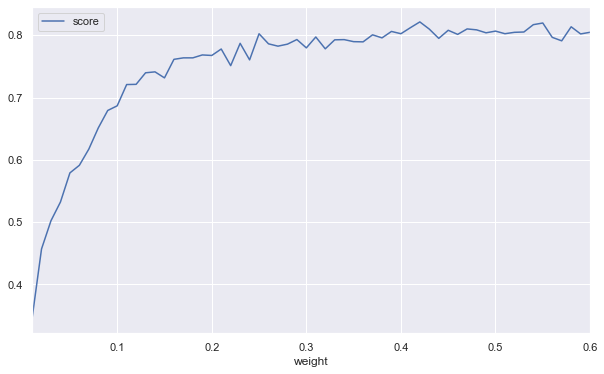

In [42]:
# How the score change over the weight setting increase
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'weight': weights })
data_out.plot(x='weight')

It seems that the best setting of weight is between 0.4~0.6

In [43]:
# Top 10 best scores
data_out.sort_values('score', ascending=False)[:5]

,score,weight
41,0.821458,0.42
54,0.819704,0.55
53,0.817045,0.54
57,0.813632,0.58
40,0.812185,0.41


Then we use optimal `class_weight` to retrain the model:

In [44]:
clf, _ = train_with_time(LogisticRegression(class_weight=optimal_class_weight), X_train, Y_train)

In [45]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [46]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18739,42
1,18,129


Even the performance is better than the baseline by decreasing FP <font color='green'>from 22 to 18 (Precision 0.81->0.88) and improving TP from 127->129 (Recall 0.74->0.75)</font>, we have no gain over recall here.

In [47]:
model_name = 'lr_cw_grid'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.997
Precision = 0.878
Recall    = 0.754
F1 Score  = 0.811


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.78')

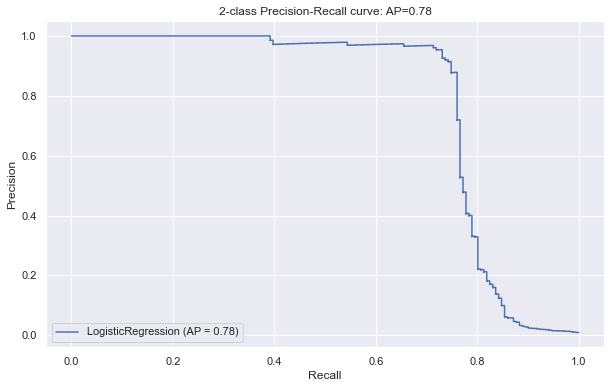

In [48]:
# PR curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

Y_score = clf.decision_function(X_test)
average_precision = average_precision_score(Y_test, Y_score)
disp = plot_precision_recall_curve(clf, X_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

For more about PR curve, please refer to this [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). Normally, we use it to predict precision while given desire recall. (It is a trade-off to find the optimal model between recall and precision)

<a id='oversampling'></a>
### <font color='darkgreen'>Oversampling</font>
[imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.over_sampling) package support below Oversampling approaches ([details](https://imbalanced-learn.org/stable/over_sampling.html#)):
![Oversampling approaches](images/12.PNG)
<br/>
So let's check our first oversampling trick [**SMOTE**](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE) here:

In [49]:
sm = SMOTE(random_state=rdm_state, sampling_strategy = 1.0)
x_train_smote, y_train_smote = sm.fit_sample(X_train, Y_train)

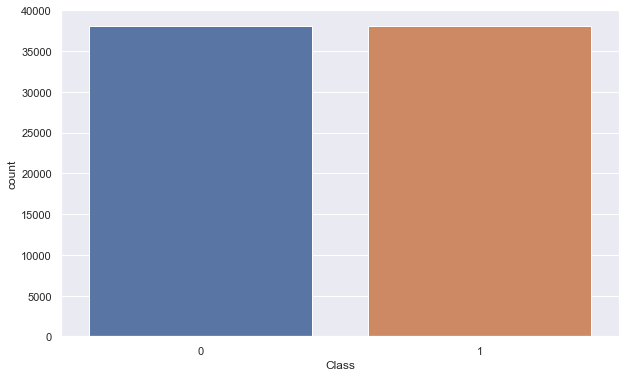

In [50]:
# The size of minority is 324. So we reduce the size of majority to 324 too
sns.countplot(y_train_smote['Class'])

The oversampling SMOTE will **generate new data point as minority class** and bring size of minority class to be close to be size of majority class. Now let's use the balanced data to train the model:

In [51]:
pipe = make_pipeline(
    SMOTE(random_state=rdm_state, sampling_strategy = 1.0),
    LogisticRegression()
)
%time clf, tt = train_with_time(pipe, X_train, Y_train)

Wall time: 768 ms


In [52]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [53]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18435,21
1,322,150


TP is improved from <font color='green'>127 to 150 (Recall 0.74->0.87)</font>; FP got worsened too <font color='red'>from 22 to **322** (Precision 0.81->0.31)</font>! <br/><br/>

In [54]:
model_name = 'lr_smote'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.982
Precision = 0.318
Recall    = 0.877
F1 Score  = 0.467


Now let's make it more advanced by applying both [**SMOTE**](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE) and `class_weight` setting (<font color='brown'>below code will take some time to complete</font>):

In [55]:
pipe = make_pipeline(
    SMOTE(random_state=rdm_state, sampling_strategy = 1.0),
    LogisticRegression()
)

weights = np.linspace(0.001, 0.7, 70)

gsc = GridSearchCV(
    estimator=pipe, 
    param_grid={'logisticregression__class_weight': [{0: x, 1: 1.0-x} for x in weights]}, 
    scoring='f1', 
    cv=5
)
%time grid_result, tt = train_with_time(gsc, X_train, Y_train)

Wall time: 3min 45s


Let's check the performance:

Best parameters : {'logisticregression__class_weight': {0: 0.669608695652174, 1: 0.33039130434782604}}


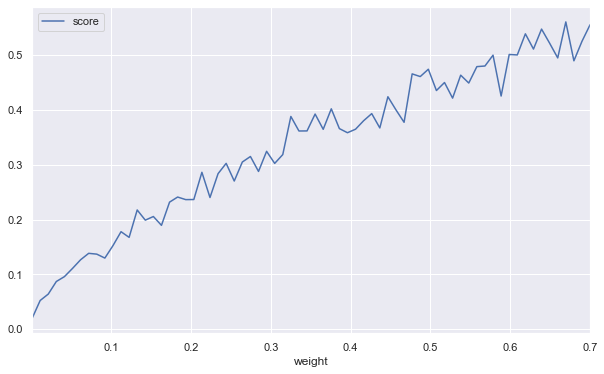

In [56]:
print("Best parameters : %s" % grid_result.best_params_)
weight_f1_score_df = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'], 'weight': weights })
weight_f1_score_df.plot(x='weight')
optimal_clz_weight_with_smote = list(grid_result.best_params_.values())[0]

In [57]:
# Let's apply the optimal setting sampling_strategy
'''
pipe = make_pipeline(
    SMOTE(random_state=rdm_state, sampling_strategy = 1.0),
    LogisticRegression(class_weight=optimal_clz_weight_with_smote)
)

pipe.fit(X_train, Y_train)
'''
Y_Test_Pred = grid_result.predict(X_test)

In [58]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18540,24
1,217,147


We increase the FP (False Positive) from <font color='red'>22 -> 217 (Precision 0.81->0.40)</font> and improve the TP (True Positive) from <font color='green'>127 -> 147 (Recall 0.74->0.86)</font> as well. Let's check more performance index:

In [59]:
model_name = 'lr_smote_with_cw_grid'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.987
Precision = 0.404
Recall    = 0.860
F1 Score  = 0.550


Let's use optimal class weight and do grid search to search optimal `sampling_strategy` of [**SMOTE**](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE):

In [60]:
pipe = make_pipeline(
    SMOTE(random_state=rdm_state),
    LogisticRegression(class_weight=optimal_clz_weight_with_smote)
)

strategy_weights = np.linspace(0.01, 0.1, 60)

gsc_sw = GridSearchCV(
    estimator=pipe, 
    param_grid={'smote__sampling_strategy': strategy_weights}, 
    scoring='f1', 
    cv=5
)
%time gsc_sw, tt = train_with_time(gsc_sw, X_train, Y_train)

Wall time: 2min 5s


Best parameters : {'smote__sampling_strategy': 0.02220338983050848}


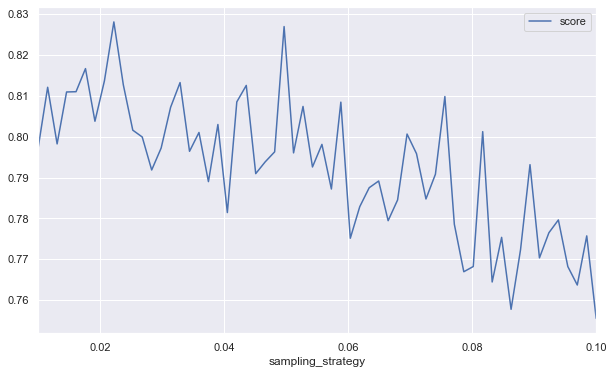

In [61]:
print("Best parameters : %s" % gsc_sw.best_params_)
weight_f1_score_df = pd.DataFrame({ 'score': gsc_sw.cv_results_['mean_test_score'], 'sampling_strategy': strategy_weights })
weight_f1_score_df.plot(x='sampling_strategy')
optimal_smote_sampling_strategy = list(gsc_sw.best_params_.values())[0]

In [62]:
# Prediction
Y_Test_Pred = gsc_sw.predict(X_test)

In [63]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18742,41
1,15,130


In [64]:
model_name = 'lr_smote_grid_with_cw_opm'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.997
Precision = 0.897
Recall    = 0.760
F1 Score  = 0.823


FP is improved <font color='green'>from 22 to 15 (Precision 0.81->0.83)</font> and TP is getting better from <font color='green'>127->130 (Recall 0.74->0.76)</font>.

Let's check another technique [**SVMSMOTE**](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) supported in [**imblean**](https://pypi.org/project/imblearn/):

In [65]:
# Check https://www.youtube.com/watch?v=g6F_zNcULKE&list=PLyQnbMWK6HUVWtYO8H2SRZLFc99oznMYU&index=12&t=2785s
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE, SVMSMOTE

# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SVMSMOTE.html
svm_sm = SVMSMOTE(random_state=rdm_state, sampling_strategy = 1.0)
x_train_res, y_train_res = svm_sm.fit_sample(X_train, Y_train)

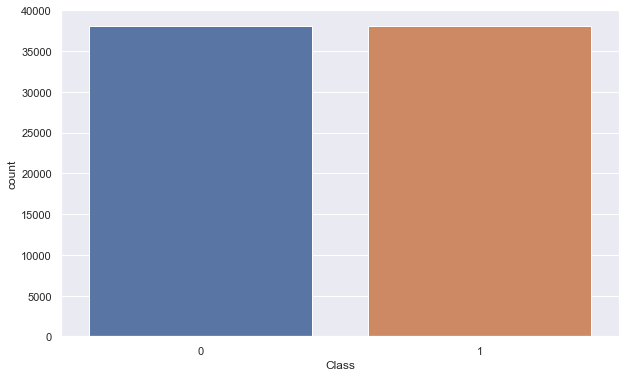

In [66]:
# The size of minority is 324. So we reduce the size of majority to 324 too
sns.countplot(y_train_res['Class'])

In [67]:
pipe = make_pipeline(
    SVMSMOTE(random_state=rdm_state, sampling_strategy = 1.0),
    LogisticRegression()
)

%time clf, tt = train_with_time(pipe, X_train, Y_train)

Wall time: 2.35 s


In [68]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [69]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18486,36
1,271,135


In [70]:
model_name = 'lr_svmsmote'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.984
Precision = 0.333
Recall    = 0.789
F1 Score  = 0.468


TP is improved from <font color='green'>127 to 135 (Recall 0.74->0.78)</font>; FP is deteriorated <font color='red'>from 22 to **271** (Precision 0.81->0.33)</font>! <br/><br/>
Actually, we can do grid search for both sampling strategy and class weight at the same time:

In [71]:
# Grid search for combination of hyperparamters which will take a long time
# Skip this one which take a long time
pipe = make_pipeline(
    SVMSMOTE(random_state=rdm_state),
    LogisticRegression()
)

strategy_weights = np.linspace(0.01, 0.2, 20)
clz_weights = np.linspace(0.01, 0.5, 20)

# 'class_weight': [{0: x, 1: 1.0-x} for x in weights]
gsc = GridSearchCV(estimator=pipe, param_grid={
    'svmsmote__sampling_strategy': strategy_weights, 
    'logisticregression__class_weight': [{0: x, 1: 1.0-x} for x in clz_weights]}, scoring='f1', cv=5, n_jobs=8)
%time grid_result, tt = train_with_time(gsc, X_train, Y_train)

Wall time: 20min 11s


In [72]:
print("Best parameters : %s" % grid_result.best_params_)
# weight_f1_score_df = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
#                                    'weight': ss_weights })
# weight_f1_score_df.plot(x='weight')
best_svmsmote_sampling_strategy = grid_result.best_params_['svmsmote__sampling_strategy']
best_class_weight = grid_result.best_params_['logisticregression__class_weight']

Best parameters : {'logisticregression__class_weight': {0: 0.47421052631578947, 1: 0.5257894736842106}, 'svmsmote__sampling_strategy': 0.01}


In [73]:
# Let's apply the optimal setting sampling_strategy
'''
pipe = make_pipeline(
    SVMSMOTE(sampling_strategy=best_svmsmote_sampling_strategy),
    LogisticRegression(class_weight=best_class_weight)
)
'''
Y_Test_Pred = grid_result.predict(X_test)

In [74]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18730,43
1,27,128


TP is improved from <font color='green'>127 to 128 (Recall 0.74->0.75)</font> slightly...

In [75]:
model_name = 'lr_svmsmote_cx'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.996
Precision = 0.826
Recall    = 0.749
F1 Score  = 0.785


The last approach of oversampling we are going to evaluate is "":

Let check last Oversampling approach [**"ADASYN"**](https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn)

In [76]:
pipe = make_pipeline(
    ADASYN(random_state=rdm_state, sampling_strategy = 1.0),
    LogisticRegression()
)

%time clf, tt = train_with_time(pipe, X_train, Y_train)

Wall time: 1.21 s


In [77]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [78]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18473,21
1,284,150


In [79]:
model_name = 'lr_adasyn'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.984
Precision = 0.346
Recall    = 0.877
F1 Score  = 0.496


TP is improved from <font color='green'>127 to 150 (Recall 0.74->0.87)</font>; FP is deteriorated <font color='red'>from 22 to **284** (Precision 0.81->0.34)</font>! <br/><br/>
Let's do grid search to obtain optimal `sampling_strategy`:

In [80]:
# Grid search for combination of hyperparamters which will take a long time
# Skip this one which take a long time
pipe = make_pipeline(
    ADASYN(random_state=rdm_state),
    LogisticRegression()
)

strategy_weights = np.linspace(0.01, 0.6, 60)

gsc = GridSearchCV(estimator=pipe, param_grid={
    'adasyn__sampling_strategy': strategy_weights
})
%time grid_result, tt = train_with_time(gsc, X_train, Y_train)

Wall time: 3min 38s


Best parameters : {'adasyn__sampling_strategy': 0.03}


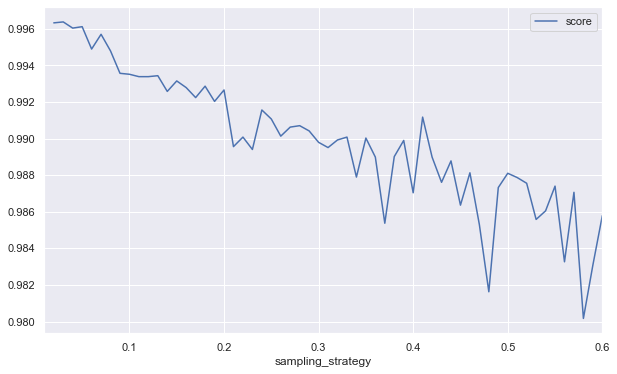

In [81]:
print("Best parameters : %s" % grid_result.best_params_)
weight_f1_score_df = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'], 'sampling_strategy': strategy_weights })
weight_f1_score_df.plot(x='sampling_strategy')
optimal_adasyn_sampling_strategy = list(gsc_sw.best_params_.values())[0]

In [82]:
# Prediction
Y_Test_Pred = grid_result.predict(X_test)

In [83]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18707,36
1,50,135


In [84]:
model_name = 'lr_adasyn_grid'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.995
Precision = 0.730
Recall    = 0.789
F1 Score  = 0.758


TP is improved from <font color='green'>127 to 135 (Recall 0.74->0.78)</font>; FP is deteriorated <font color='red'>from 22 to **50** (Precision 0.81->0.73)</font>! <br/><br/>
So far we have conducted below approaches:

In [85]:
perf_store.keys()

dict_keys(['lr_baseline', 'lr_us_cc', 'lr_us_tl', 'lr_cw', 'lr_cw_grid', 'lr_smote', 'lr_smote_with_cw_grid', 'lr_smote_grid_with_cw_opm', 'lr_svmsmote', 'lr_svmsmote_cx', 'lr_adasyn', 'lr_adasyn_grid'])

Let's ranking all the approaches and got the top5 for discussion:

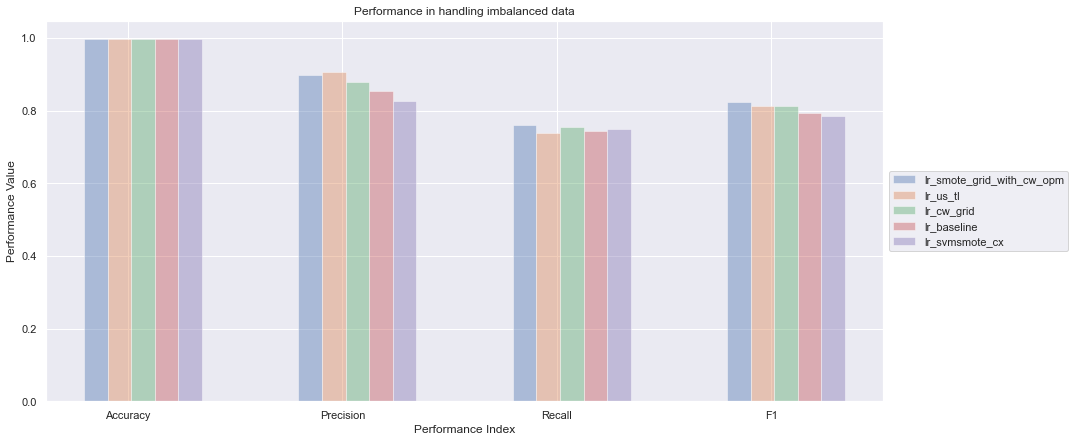

In [86]:
import matplotlib.pyplot as plt
import re

def show_top5_F1(skip_ptn=None):
    top_n = 5
    plt.figure(figsize=(15, 7))
    bar_width = 0.11
    tech_names = []
    pref_store_items =  perf_store.items()
    if skip_ptn:
        pref_store_items = list(filter(lambda t: not skip_ptn.search(t[0]), pref_store_items))
        
    perf_datas_sorted = sorted(pref_store_items, key=lambda t: t[1][3], reverse=True)[:top_n]
    for i, (tech_name, datas) in enumerate(perf_datas_sorted):                    
        index = np.arange(len(datas))
        plt.bar(index + i*bar_width,
                datas, 
                bar_width,
                alpha=.4,
                label=tech_name) 
    
        tech_names.append(tech_name)
    
    plt.ylabel("Performance Value")
    plt.xlabel("Performance Index")
    plt.title("Performance in handling imbalanced data")
    plt.xticks(index+.3 / 2 , ["Accuracy", "Precision", "Recall", "F1"])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    plt.grid(True)
    plt.show()
    
show_top5_F1(re.compile('^xgb.*'))
# show_top5_F1()

So far the best F1 we can get by using Logistric regression **lr_cw_grid** (Class weight with grid search):
* Accuracy =  99.6%
* Precision =  88.6%
* Recall =  74.4%
* F1 Score =  80.9%

<a id='other_models_svm'></a>
### <font color='darkgreen'>Other Machine Learning Model (SVM)</font>
Let's use other ML model [**SVC**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from scikit-learn to see how it performs:

In [87]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(
    StandardScaler(), 
    SVC(gamma='scale', kernel='linear', cache_size=300)
)
%time clf, tt = train_with_time(pipe, X_train, Y_train)

Wall time: 30.5 s


In [88]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [89]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18755,37
1,2,134


We both improve TP from <font color='green'>127 to 134 (Recall 0.74->0.78)</font> and FP from <font color='green'>from 22 to 2 (Precision 0.81->0.94)</font>! <br/><br/>

In [90]:
model_name = 'svm'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.985
Recall    = 0.784
F1 Score  = 0.873


Let's do grid search for both optimal parameter `class_weight` setting and `kernel` setting:

In [91]:
# This cell will take a long time: Wall time: 25min 11s
cz_weights = np.linspace(0.1, 0.5, 30)
# c_values = np.linspace(0.1, 1, 10)
# 'class_weight': [{0: x, 1: 1.0-x} for x in weights]
gsc = GridSearchCV(
    estimator=clf,
    param_grid={
        'svc__class_weight': [{0: x, 1: 1.0-x} for x in cz_weights],
        'svc__kernel': ["linear", "poly", "rbf", "sigmoid", "precomputed"],
        # 'svc_gamma': ['auto', 'scale']
        # 'svc__C': c_values
    },
    scoring='f1',
    cv=5
)
%time grid_result, tt = train_with_time(gsc, X_train, Y_train)

Wall time: 25min 12s


Best parameters : {'svc__class_weight': {0: 0.1, 1: 0.9}, 'svc__kernel': 'linear'}




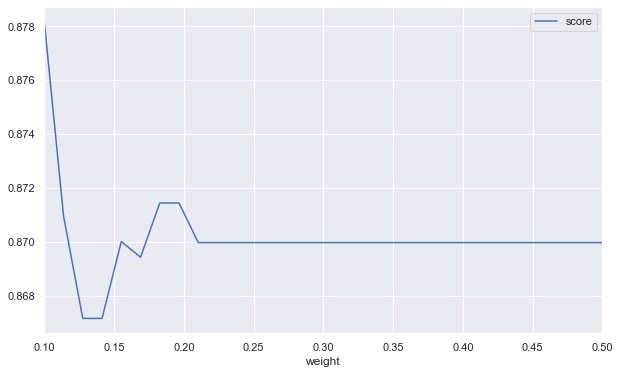

In [92]:
# Extract best hyper parameter(s)
print("Best parameters : %s\n\n" % grid_result.best_params_)
linear_score = grid_result.cv_results_['mean_test_score'][0::5]

weight_f1_score_df = pd.DataFrame({ 'score': linear_score, 'weight': cz_weights })
weight_f1_score_df.plot(x='weight')

best_clz_weight = grid_result.best_params_['svc__class_weight']
best_kernel_type = grid_result.best_params_['svc__kernel']

In [93]:
# Let's apply the optimal setting sampling_strategy
# pipe = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight=best_clz_weight, kernel=best_kernel_type)).fit(X_train, Y_train)

# gsc.fit(X_train, Y_train)

Y_Test_Pred = grid_result.predict(X_test)

In [94]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18751,35
1,6,136


We both improve TP from <font color='green'>127 to 137 (Recall 0.74->0.80)</font> and FP from <font color='green'>from 22 to 3 (Precision 0.81->0.97)</font>. <br/><br/>

In [95]:
model_name = 'svm_grid'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.958
Recall    = 0.795
F1 Score  = 0.869


What if we apply SMOTE here too:

In [96]:
# Let's apply the optimal setting sampling_strategy
pipe = make_pipeline(
    # SVMSMOTE(random_state=rdm_state, sampling_strategy=best_svmsmote_sampling_strategy),
    ADASYN(random_state=rdm_state, sampling_strategy=0.03),
    StandardScaler(), 
    SVC(gamma='auto', kernel=best_kernel_type, class_weight=best_clz_weight)
).fit(X_train, Y_train)

%time clf, tt = train_with_time(pipe, X_train, Y_train)

Y_Test_Pred = clf.predict(X_test)

Wall time: 5.42 s


In [97]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18735,27
1,22,144


We both improve TP from <font color='green'>127 to 144 (Recall 0.74->0.84)</font>. <br/><br/>

In [98]:
model_name = 'svm_cx'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.997
Precision = 0.867
Recall    = 0.842
F1 Score  = 0.855


<a id='other_models_xgboost'></a>
### <font color='darkgreen'>Other Machine Learning Model (XGBoost)</font>
Another model to try is [**XGBoost**](https://xgboost.readthedocs.io/en/latest/index.html):

In [99]:
from xgboost import XGBClassifier

clf = XGBClassifier(scale_pos_weight=1, random_state=rdm_state)
%time clf, tt = train_with_time(clf, X_train, Y_train)

Wall time: 4.44 s


In [100]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [101]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18754,34
1,3,137


In [102]:
model_name = 'xgb'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.979
Recall    = 0.801
F1 Score  = 0.881


We increased TP from <font color='green'>127 to 137 (Recall 0.74->0.80)</font> and decreased FP <font color='green'>from 22 to 3 (Precision 0.81->0.97)</font>. Both metrics are improved! <br/><br/>
XGBoost also supports hyperparameter `scale_pos_weight` to deal with imbalanced data ([more parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)):
> A sensible default value to set for the `scale_pos_weight` hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the `scale_pos_weight` can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

In [103]:
# This cell will take a long time: Wall time: 18min 47s
sp_weights = np.linspace(1, 100, 100)

gsc = GridSearchCV(
    estimator=clf,
    param_grid={        
        'scale_pos_weight': sp_weights,        
    },
    scoring='f1',
    cv=5
)

%time grid_result, tt = train_with_time(gsc, X_train, Y_train)

Wall time: 33min 3s


Best parameters : {'scale_pos_weight': 28.0}




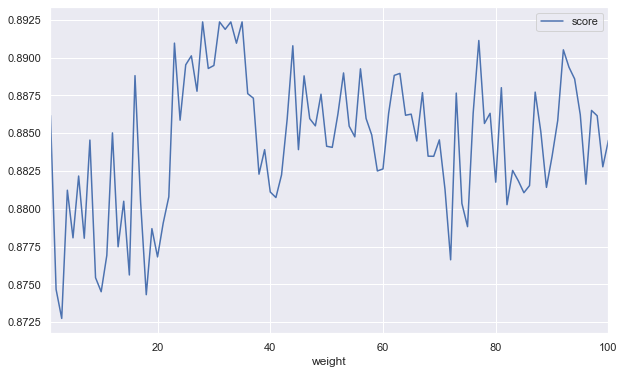

In [104]:
# Extract best hyper parameter(s)
print("Best parameters : %s\n\n" % grid_result.best_params_)
score = grid_result.cv_results_['mean_test_score']

weight_f1_score_df = pd.DataFrame({ 'score': score, 'weight': sp_weights })
weight_f1_score_df.plot(x='weight')

best_sp_weight = grid_result.best_params_['scale_pos_weight']

In [105]:
# Prediction
Y_Test_Pred = grid_result.predict(X_test)

In [106]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18749,33
1,8,138


In [107]:
model_name = 'xgb_grid'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.945
Recall    = 0.807
F1 Score  = 0.871


The performance doesn't change much with help of grid search.

<a id='evaluation'></a>
### <font color='darkgreen'>Evaluation of all techniques</font>
Let's check how those techniques perform:

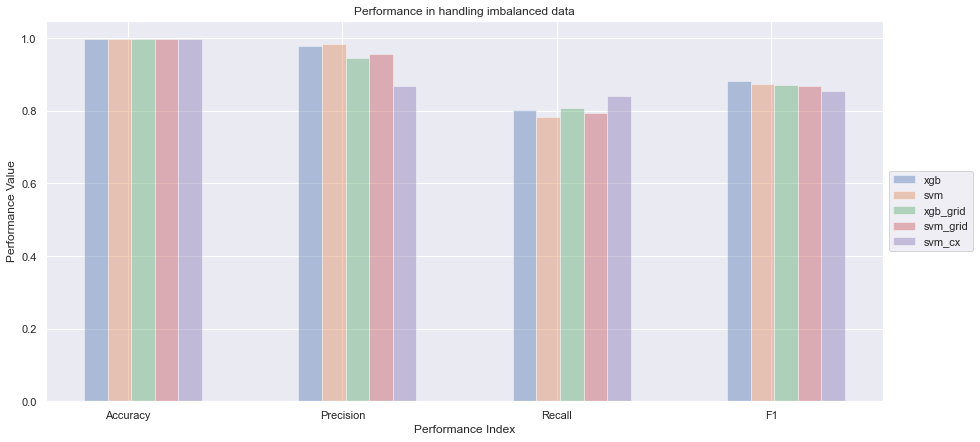

In [108]:
show_top5_F1()

In order to obtain best performance, we have to conduct many experiment to find the best technique for our imbalanced dataset.

Also we might be interested in the time in conducting training:

In [109]:
sorted(time_cost_store.items(), key=lambda t: t[1])

[('lr_us_cc', 0.05175),
 ('lr_cw', 0.276087),
 ('lr_baseline', 0.416218),
 ('lr_us_tl', 0.437807),
 ('lr_smote', 0.767579),
 ('lr_adasyn', 1.208903),
 ('lr_svmsmote', 2.345813),
 ('xgb', 4.444586),
 ('svm_cx', 5.419368),
 ('svm', 30.480182),
 ('lr_cw_grid', 115.559117),
 ('lr_smote_grid_with_cw_opm', 125.950598),
 ('lr_adasyn_grid', 218.386802),
 ('lr_smote_with_cw_grid', 225.268368),
 ('lr_svmsmote_cx', 1211.82096),
 ('svm_grid', 1512.504929),
 ('xgb_grid', 1983.246175)]

All methods with grid search will take a lot of time which is quite costly.

<a id='anomaly'></a>
## <font color='darkblue'>Anomaly Detection</font>
From this [post](https://github.com/johnklee/ml_articles/blob/master/others/anomaly_detection_using_isolation_forest_in_python/anomaly_detection_using_isolation_forest_in_python.ipynb), we learned that abnomal detection can help in detection:

In [110]:
from sklearn.ensemble import IsolationForest

isf_model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1), max_features=1.0)
X_no_time = X.loc[:, X.columns!='Time']
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00


In [113]:
%time isf_model.fit(X_no_time)

Wall time: 2.18 s


IsolationForest(contamination=0.1, n_estimators=50)

In [114]:
scores = isf_model.decision_function(X_no_time)
anomaly = isf_model.predict(X_no_time)

In [115]:
anomaly_score = []
num_of_anomaly, num_of_normal = 0, 0
for s, a in zip(scores, anomaly):
    if a == -1:
        num_of_anomaly += 1
        anomaly_score.append(abs(s))
    else:
        num_of_normal += 1
        anomaly_score.append(0)

print(f"{num_of_anomaly}/{num_of_normal}")

5736/51619


In [117]:
X_no_time['anomaly_scores'] = anomaly_score
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0.039332
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,0.000000
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,0.035544
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,0.126303
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,0.128532


In [118]:
X_train_an, X_test_an, Y_train_an, Y_test_an = train_test_split(X_no_time, Y, test_size=0.33, random_state=rdm_state)
X_train_an.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores
32921,-2.675244,-0.323257,0.517195,-0.376636,-1.708371,-0.537232,-0.931266,1.431398,0.416819,-1.303442,...,0.018158,-0.029245,0.509378,0.587022,-0.952318,0.637756,-0.194570,-0.515118,61.16,0.0
19127,-0.868260,0.932589,0.571916,-0.107275,2.157593,3.934438,-0.238673,1.083028,-0.410057,0.297408,...,0.044927,0.189939,-0.336198,1.006837,0.568693,-0.082223,0.461912,0.222029,22.00,0.0
28808,0.343044,-1.127913,0.081464,1.761303,-0.373600,0.748892,0.176161,0.194697,1.544616,-0.494604,...,0.037811,-0.362887,-0.346195,-0.370522,0.332889,-0.373180,-0.057848,0.058355,389.40,0.0
47569,2.218237,-1.463150,-0.785748,-1.621523,-1.298160,-0.447642,-1.198453,-0.121523,-1.420388,1.703463,...,-0.106722,0.166968,0.174979,-0.338982,-0.229865,-0.182061,0.016310,-0.054457,39.20,0.0
55866,2.074809,0.003273,-1.109802,0.373805,-0.003781,-1.111854,0.231792,-0.368320,0.437249,0.051683,...,-0.290761,-0.663909,0.313613,-0.089711,-0.252816,0.202636,-0.065831,-0.059949,0.99,0.0


In [119]:
pipe = make_pipeline(
    StandardScaler(), 
    SVC(gamma='scale', kernel='linear', cache_size=300)
)
%time clf, tt = train_with_time(pipe, X_train_an, Y_train_an)

Wall time: 13.6 s


In [120]:
# Prediction
Y_Test_Pred = clf.predict(X_test_an)

In [121]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test_an[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18755,37
1,2,134


In [122]:
model_name = 'svm_an'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.985
Recall    = 0.784
F1 Score  = 0.873


In [123]:
# This cell will take a long time
cz_weights = np.linspace(0.1, 0.5, 30)
# c_values = np.linspace(0.1, 1, 10)
# 'class_weight': [{0: x, 1: 1.0-x} for x in weights]
gsc = GridSearchCV(
    estimator=clf,
    param_grid={
        'svc__class_weight': [{0: x, 1: 1.0-x} for x in cz_weights],
        'svc__kernel': ["linear", "poly", "rbf", "sigmoid", "precomputed"],
        # 'svc_gamma': ['auto', 'scale']
        # 'svc__C': c_values
    },
    scoring='f1',
    cv=5
)
%time grid_result, tt = train_with_time(gsc, X_train_an, Y_train_an)

Wall time: 25min 52s


Best parameters : {'svc__class_weight': {0: 0.1, 1: 0.9}, 'svc__kernel': 'linear'}




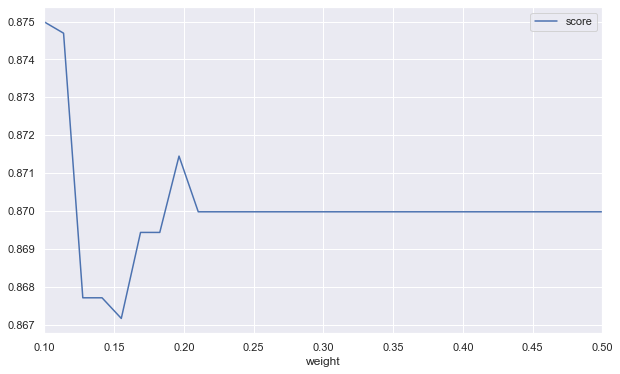

In [124]:
# Extract best hyper parameter(s)
print("Best parameters : %s\n\n" % grid_result.best_params_)
linear_score = grid_result.cv_results_['mean_test_score'][0::5]

weight_f1_score_df = pd.DataFrame({ 'score': linear_score, 'weight': cz_weights })
weight_f1_score_df.plot(x='weight')

best_clz_weight = grid_result.best_params_['svc__class_weight']
best_kernel_type = grid_result.best_params_['svc__kernel']

In [125]:
# Let's apply the optimal setting sampling_strategy
# pipe = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight=best_clz_weight, kernel=best_kernel_type)).fit(X_train, Y_train)

# gsc.fit(X_train, Y_train)

Y_Test_Pred = grid_result.predict(X_test_an)

In [126]:
model_name = 'svm_grid_an'
perf_store[model_name] = generate_model_report(Y_test_an, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.965
Recall    = 0.795
F1 Score  = 0.872


In [127]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test_an[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18752,35
1,5,136


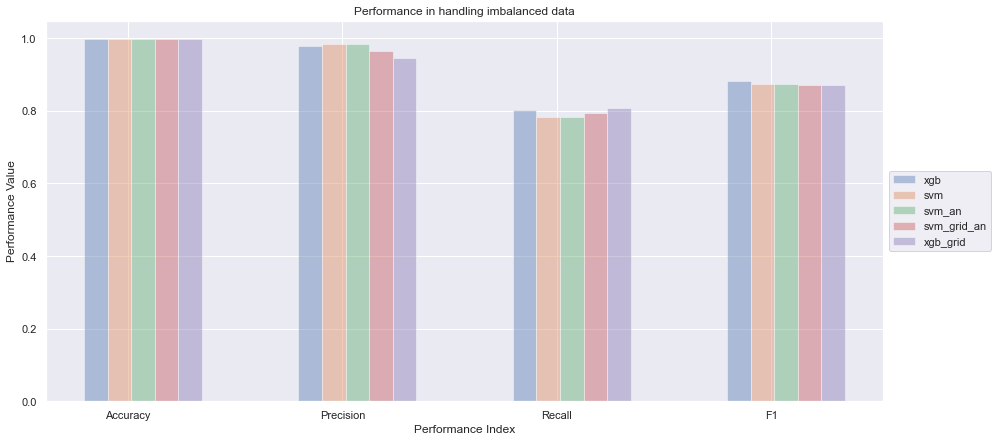

In [128]:
show_top5_F1()

## <font color='darkblue'>Feature Engineering</font>
There is a [post](https://www.kaggle.com/vishal1508/predicting-fraud-with-tensorflow-a03968) explaning well on how to apply feature engineering to deal with Fraud detection data set. We are going to do the same thing to see how feature engineering can help to boost our perfmance here. Before all, let's explore the data set:

In [129]:
# Time statistic information
print ("Fraud")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Time[df.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal
count     56863.000000
mean      94743.188664
std       47453.600903
min           2.000000
25%       54148.000000
50%       84597.000000
75%      139205.000000
max      172782.000000
Name: Time, dtype: float64


In [168]:
# Amount statistic information
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    56863.000000
mean        89.307623
std        245.655345
min          0.000000
25%          5.845000
50%         22.210000
75%         77.700000
max      12910.930000
Name: Amount, dtype: float64


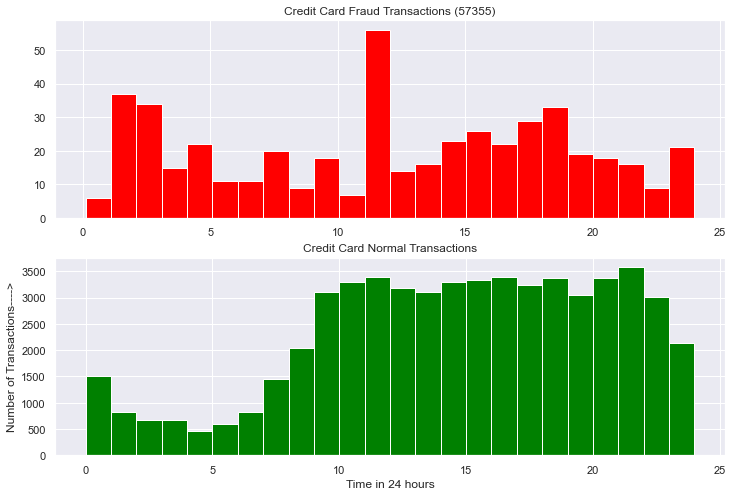

In [192]:
def time_hist(bins=24, amount_range=None):
    f, (ax1, ax2) = plt.subplots(2, 1 , figsize=(12,8),edgecolor='black')

    if amount_range is None:
        target_df = df
    else:
        min_amount = amount_range[0] if amount_range[0] >=0 else 0
        max_amount = amount_range[1] if amount_range[1] >=0 else 20000
        target_df = df[(df['Amount'] > min_amount) & (df['Amount'] < max_amount)]
        
    target_df['Hours'] = target_df['Time'] / 3600 % 24
    ax1.hist(target_df.Hours[target_df.Class == 1], bins=bins, color='red')
    ax1.set_title(f'Credit Card Fraud Transactions ({target_df.shape[0]})')

    ax2.hist(target_df.Hours[target_df.Class == 0], bins=bins, color='green')
    ax2.set_title('Credit Card Normal Transactions')

    plt.xlabel('Time in 24 hours')
    plt.ylabel('Number of Transactions---->')
    plt.show()
    
time_hist()

<b>The 'Time' feature looks pretty similar across both types of transactions.</b> You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time.

Let's check for some amount range vs time:

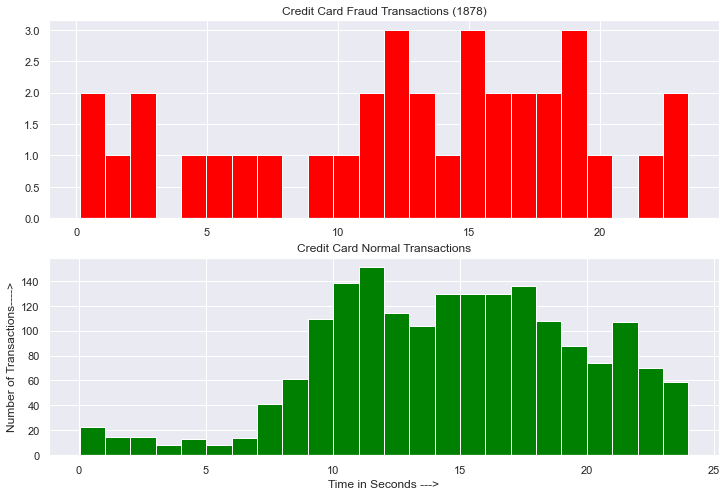

In [191]:
time_hist(amount_range=(500, 3000))

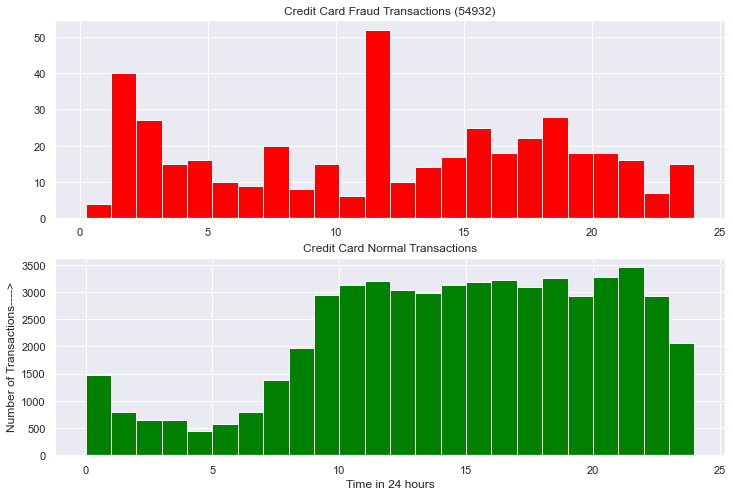

In [193]:
time_hist(amount_range=(-1, 500))

Now let's see if the transaction amount differs between the two types.

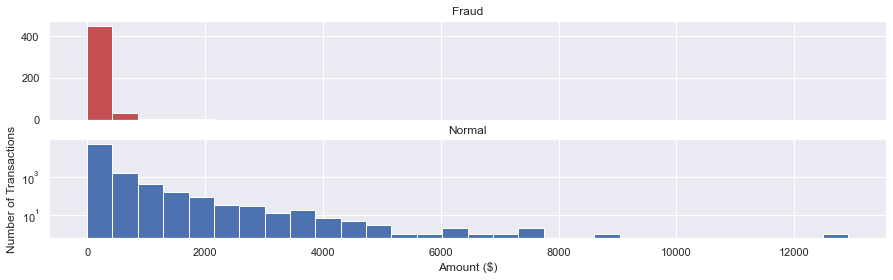

In [131]:
bins = 30
hist, bin_edges = np.histogram(df.Amount[df.Class == 0], bins=bins)
bin_edges[:5]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,4))

ax1.hist(df.Amount[df.Class == 1], bins = bin_edges, color='r')
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bin_edges)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [132]:
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0.039332
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,0.000000
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,0.035544
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,0.126303
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,0.128532


<b>Most fraudulent transactions are small amounts, less than 3000 roughly</b>. So let's add one more feature here:

In [133]:
X_no_time['Amount_max_fraud'] = 1
X_no_time.loc[df.Amount <= 3000, 'Amount_max_fraud'] = 0
X_no_time[['Amount', 'Amount_max_fraud']]

,Amount,Amount_max_fraud
0,0.00,0
1,529.00,0
2,239.93,0
3,59.00,0
4,1.00,0
...,...,...
57350,63.60,0
57351,60.00,0
57352,2.31,0
57353,39.99,0


In [134]:
X_no_time.shape

(57355, 31)

Next, let's take a look at the anonymized features.

In [135]:
#Select only the anonymized features.
v_features = X_no_time.iloc[:,0:28].columns
v_features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

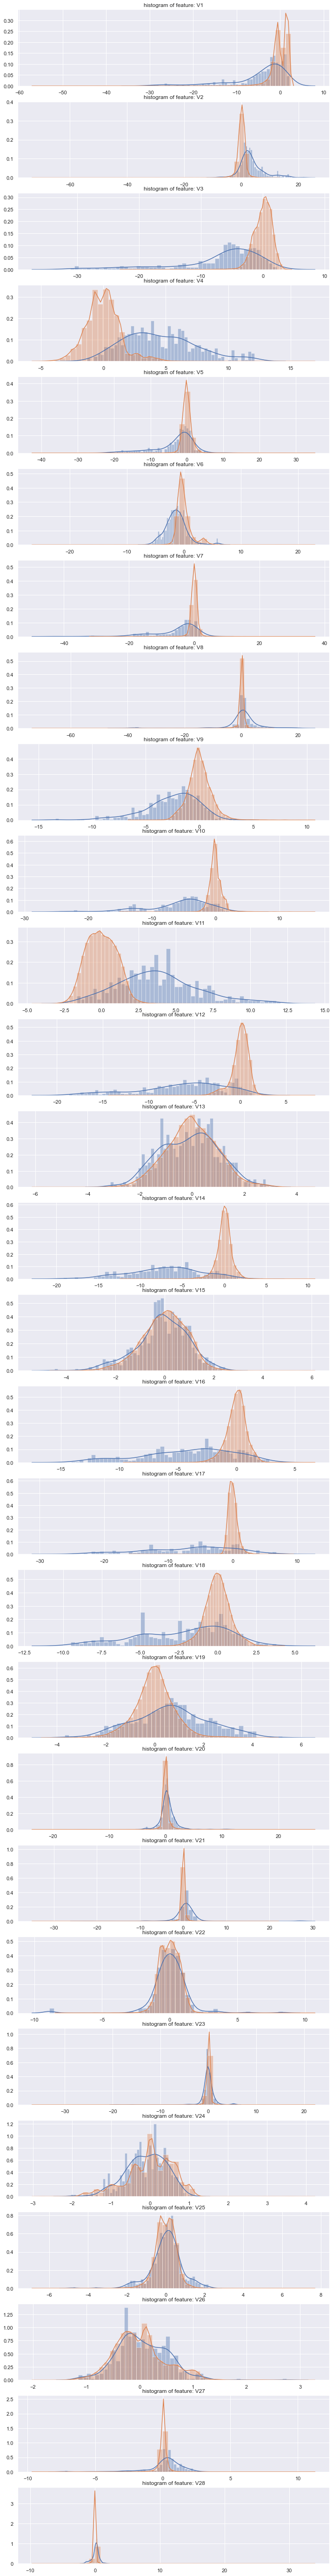

In [136]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(31, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
    
plt.show()

We can drop all of the features that have very similar distributions between the two types of transactions and add some customized features here:

In [137]:
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores,Amount_max_fraud
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0.039332,0
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,0.000000,0
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,0.035544,0
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,0.126303,0
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,0.128532,0


In [138]:
X_no_time = X_no_time.drop(['V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V28'], axis =1)

Based on the plots above, these features are created to identify values where fraudulent transaction are LESS common.

In [139]:
X_no_time['V1_'] = X_no_time.V1.map(lambda x: 1 if x < -10 else 0)
X_no_time['V2_'] = X_no_time.V2.map(lambda x: 1 if x > 10 else 0)
X_no_time['V3_'] = X_no_time.V3.map(lambda x: 1 if x < -5 else 0)
X_no_time['V4_'] = X_no_time.V4.map(lambda x: 1 if x > 5 else 0)
X_no_time['V5_'] = X_no_time.V5.map(lambda x: 1 if x < -5 else 0)
X_no_time['V6_'] = X_no_time.V6.map(lambda x: 1 if x < -5 else 0)
X_no_time['V7_'] = X_no_time.V7.map(lambda x: 1 if x < -5 else 0)
X_no_time['V9_'] = X_no_time.V9.map(lambda x: 1 if x < -5 else 0)
X_no_time['V10_'] = X_no_time.V10.map(lambda x: 1 if x < -5 else 0)
X_no_time['V11_'] = X_no_time.V11.map(lambda x: 1 if x > 5 else 0)
X_no_time['V12_'] = X_no_time.V12.map(lambda x: 1 if x < -5 else 0)
X_no_time['V14_'] = X_no_time.V14.map(lambda x: 1 if x < -5 else 0)
X_no_time['V16_'] = X_no_time.V14.map(lambda x: 1 if x < -5 else 0)
X_no_time['V17_'] = X_no_time.V17.map(lambda x: 1 if x < -5 else 0)
X_no_time['V18_'] = X_no_time.V18.map(lambda x: 1 if x < -5 else 0)
X_no_time['V19_'] = X_no_time.V19.map(lambda x: 1 if x > 2 else 0)
X_no_time['V21_'] = X_no_time.V21.map(lambda x: 1 if x > 1 else 0)

Now let's use our best model so far (`svm_cx`) to do the training:

In [140]:
# Split the train/test set again because we add new features
target_column_name = 'Class'
# X = df.loc[:, df.columns!=target_column_name]
# Y = df.loc[:, df.columns==target_column_name]
X_train, X_test, Y_train, Y_test = train_test_split(X_no_time, Y, test_size=0.33, random_state=rdm_state)

In [141]:
# Make sure the new df contains the new features
pd.set_option("display.max_columns", 101)
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,V27,Amount,anomaly_scores,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_
32921,-2.675244,-0.323257,0.517195,-0.376636,-1.708371,-0.537232,-0.931266,0.416819,-1.303442,0.143747,0.822738,0.695036,0.707574,0.212050,0.177324,0.139044,0.018158,-0.194570,61.16,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19127,-0.868260,0.932589,0.571916,-0.107275,2.157593,3.934438,-0.238673,-0.410057,0.297408,-0.215889,-0.384410,0.108149,0.261037,-0.710854,0.911064,0.879255,0.044927,0.461912,22.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28808,0.343044,-1.127913,0.081464,1.761303,-0.373600,0.748892,0.176161,1.544616,-0.494604,2.034569,-2.157655,2.177388,-0.718845,1.146524,-0.364540,-0.756980,0.037811,-0.057848,389.40,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47569,2.218237,-1.463150,-0.785748,-1.621523,-1.298160,-0.447642,-1.198453,-1.420388,1.703463,0.494807,0.123070,-0.428371,-0.238108,0.073819,0.481723,0.210614,-0.106722,0.016310,39.20,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55866,2.074809,0.003273,-1.109802,0.373805,-0.003781,-1.111854,0.231792,0.437249,0.051683,-0.744134,0.792032,0.115909,-0.097750,-0.384933,-0.914438,0.196880,-0.290761,-0.065831,0.99,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [142]:
# Training
pipe = make_pipeline(
    # SVMSMOTE(random_state=rdm_state, sampling_strategy=best_svmsmote_sampling_strategy),
    # ADASYN(random_state=rdm_state, sampling_strategy=0.03),
    StandardScaler(), 
    SVC(gamma='auto', kernel=best_kernel_type, class_weight=best_clz_weight)
).fit(X_train, Y_train)

%time clf, tt = train_with_time(pipe, X_train, Y_train)

Wall time: 8.05 s


In [143]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [144]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18752,33
1,5,138


In [145]:
model_name = 'svm_cx_fe'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.965
Recall    = 0.807
F1 Score  = 0.879


We have <b>the best recall</b> by improving TP <font color='green'>127 to 138 (Recall 0.74->0.80)</font> without sacrificing FP (<font color='green'>from 22 to 5 (Precision 0.81->0.96)</font>). So the new features did help our model to obtain better performance. Let's try on XGBoost:

In [146]:
# Training
clf = XGBClassifier(random_state=rdm_state)

clf.fit(X_train, Y_train)

%time pipe, tt = train_with_time(pipe, X_train, Y_train)

Wall time: 8.13 s


In [147]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [148]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, Y_test[target_column_name], 
            rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,18753,32
1,4,139


In [149]:
model_name = 'xgb_grid_fe'
perf_store[model_name] = generate_model_report(Y_test, Y_Test_Pred)
time_cost_store[model_name] = tt

Accuracy  = 0.998
Precision = 0.972
Recall    = 0.813
F1 Score  = 0.885


XGBoost with grid search and feature engineering can obtain best recall (TP=135; Recall=80.4%) so far.

Finally, let's check the best model we can get:

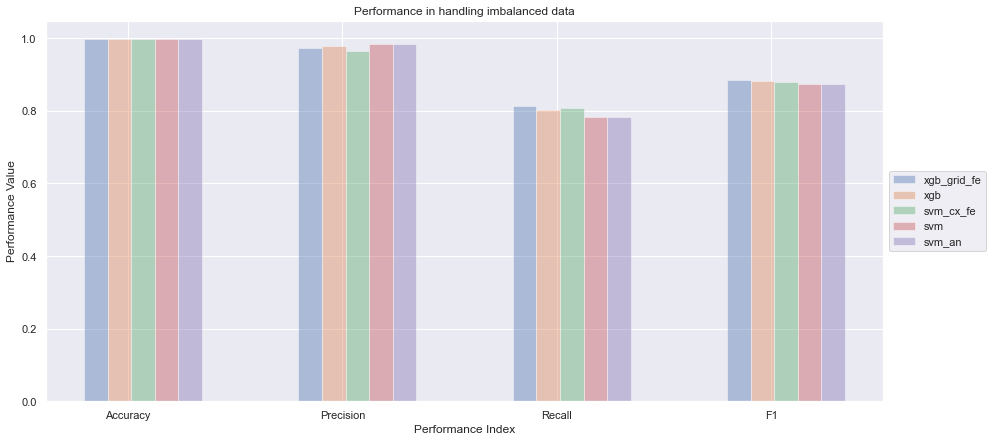

In [150]:
show_top5_F1()

The model with best F1 is `xgb_grid_fe`:
* Accuracy =  99.79%
* Precision =  97.2%
* Recall =  81.35%
* F1 Score =  88.5%

## <font color='darkblue'>Error Analysis</font>
Next thing we can do is to do <b>error analysis</b>:

In [151]:
# Collect FN(37), FP(9)
fp_ni = []
fn_ni = []
for i, (p, r) in enumerate(zip(Y_Test_Pred, Y_test['Class'])):
    if p == 1 and r == 0:
        fp_ni.append(i)
    elif p == 0 and r == 1:
        fn_ni.append(i)
        
print("FP={}; FN={}".format(len(fp_ni), len(fn_ni)))

FP=4; FN=32


In [152]:
fn_df, fp_df = df.iloc[fn_ni], df.iloc[fp_ni]

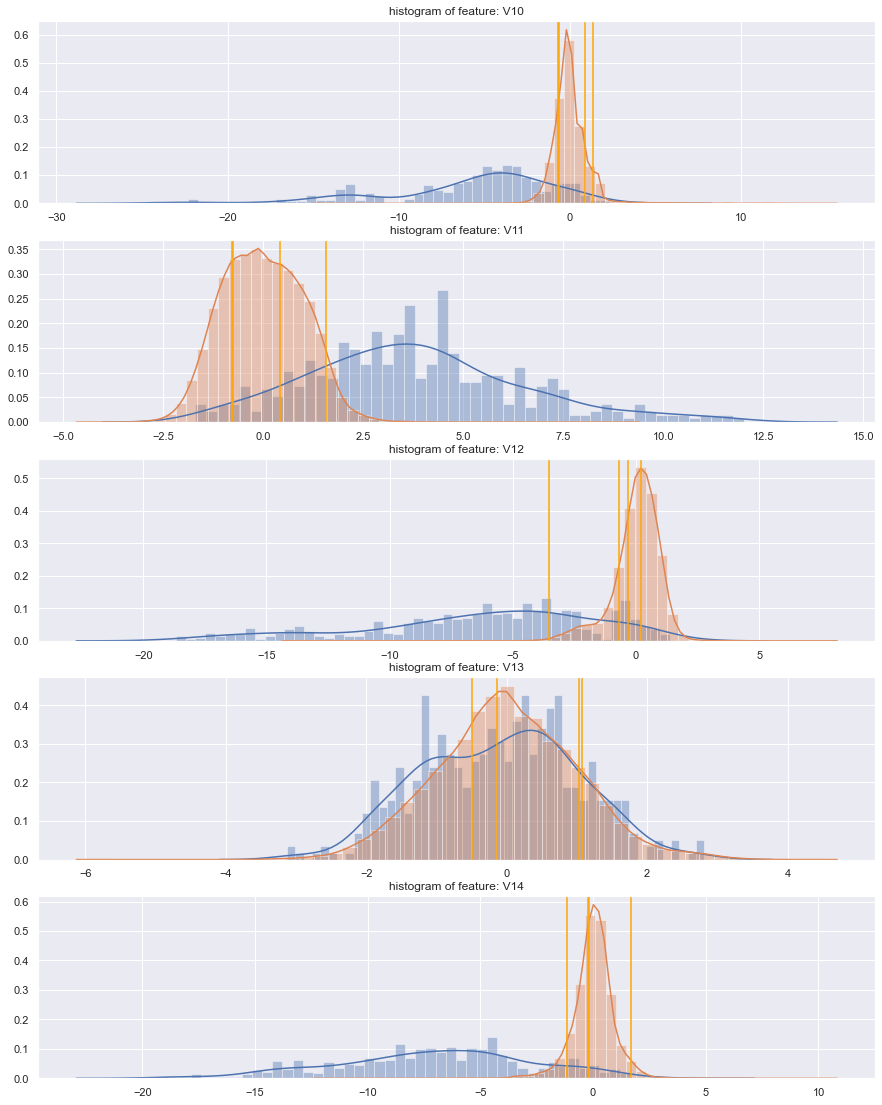

In [153]:
# For FP analysis on features (9)
v_features = df.iloc[:,10:15].columns
plt.figure(figsize=(15, 28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))    
        
    for index, row in fp_df.iterrows():
        ax.axvline(x=row[cn], color='orange')
        
plt.show()

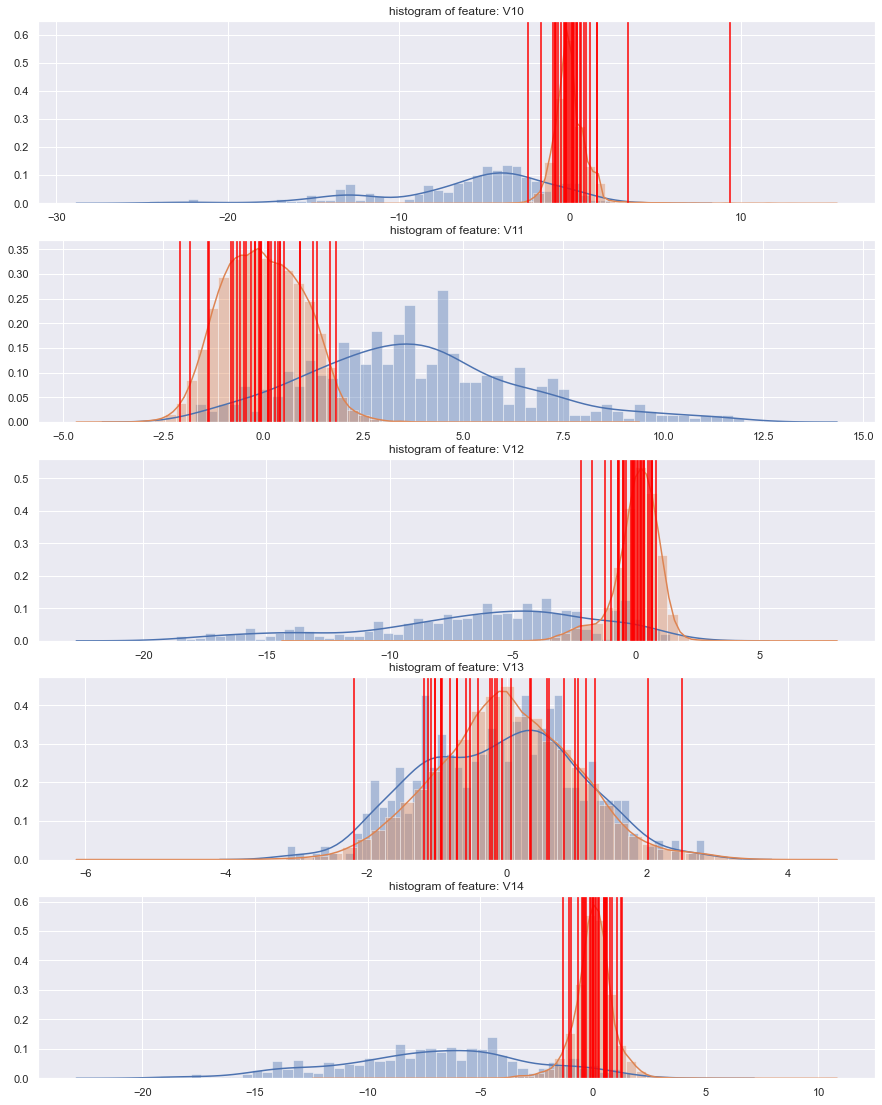

In [154]:
# For FN analysis (37)
v_features = df.iloc[:,10:15].columns
plt.figure(figsize=(15, 28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
        
    for index, row in fn_df.iterrows():
        ax.axvline(x=row[cn], color='red')
        
plt.show()

The goal of error analysis aims to look for new features or possible hyperparameters turning in order to tackle those FP and FN tactically.

## <font color='darkblue'>Lesson Learned</font>
* Undersampling/Oversampling can help us to improve recall. But it also may deteriorate precision too.
* Grid search is helpful. But it will increase the cost of training time.
* Feature engineering is a kind of art and you need plenty of time to explore to data in order to find useful feature(s).
* Error analysis can be helpful too to know the propensity of FP and FN.

### <font color='darkgreen'>Possible future work</font>
* Use algorithm XGBoost to do the experiment.
* Apply unsupervised learning such as anomaly detection to enrich features.
* More

## <font color='darkblue'>Supplement</font>
* [A Gentle Introduction to Imbalanced Classification](https://machinelearningmastery.com/what-is-imbalanced-classification/)
> An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. The distribution can vary from a slight bias to a severe imbalance where there is one example in the minority class for hundreds, thousands, or millions of examples in the majority class or classes.
* [SMOTE and ADASYN](https://www.youtube.com/watch?v=Qkcce86nqFQ)
* [How to Configure XGBoost for Imbalanced Classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/)
* [Machine LearningTutorial | Resampling 2: Cluster Centroids and Tomek Links | Rohit Ghosh | GreyAtom](https://www.youtube.com/watch?v=odXE7WiO2GM)
* [Predicting Fraud with TensorFlow: Feature engineering](https://www.kaggle.com/vishal1508/predicting-fraud-with-tensorflow-a03968)
* [Natalie Hockham: Machine learning with imbalanced data sets](https://www.youtube.com/watch?v=X9MZtvvQDR4&list=PLyQnbMWK6HUUgr9FmrkkuUl3ts7o7T7r4&index=63)
* [SMOTE (Synthetic Minority Oversampling Technique) for Handling Imbalanced Datasets](https://www.youtube.com/watch?v=U3X98xZ4_no&list=PLyQnbMWK6HUUgr9FmrkkuUl3ts7o7T7r4&index=62)
* [Confusion Matrix in Machine Learning](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)
* [Aditya Lahiri: Dealing With Imbalanced Classes in Machine Learning | PyData New York 2019](https://www.youtube.com/watch?v=6M2d2n-QXCc&t=782s)
* [Class Weights for Handling Imbalanced Datasets](https://www.youtube.com/watch?v=Kp31wfHpG2c&list=PLyQnbMWK6HUVWtYO8H2SRZLFc99oznMYU&index=6&t=541s)
* [SMOTE - Synthetic Minority Oversampling Technique](https://www.youtube.com/watch?v=FheTDyCwRdE&list=PLyQnbMWK6HUVWtYO8H2SRZLFc99oznMYU&index=4)
* [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
* [CellStrat - Classification of Imbalanced data](https://www.youtube.com/watch?v=g6F_zNcULKE&list=PLyQnbMWK6HUVWtYO8H2SRZLFc99oznMYU&index=12&t=2785s)
* [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
* [tSNE to visualize digits](https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html)
* [Day20 - Matplotlib資料視覺化進階！](https://ithelp.ithome.com.tw/articles/10196410)
* [FAQ - How to put the legend out of the plot](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot)
* [Underfit vs overfit: do I need more data, or more complex models?](http://gael-varoquaux.info/interpreting_ml_tuto/content/01_how_well/03_underfit_vs_overfit.html)